
# End-to-End Regression Modeling (TMDB)

This notebook predicts `popularity` with:
- feature engineering from raw data
- multiple regression models
- K-fold cross-validation comparison
- holdout evaluation
- visual diagnostics
- SHAP feature importance


In [1]:

import ast
import json
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
os.environ.setdefault('MPLCONFIGDIR', '/tmp')
sns.set_theme(style='whitegrid')

RANDOM_STATE = 42
ARTIFACT_DIR = Path('models/artifacts/regression')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)


In [2]:

def safe_parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        x = x.strip()
        if x in ('', '[]'):
            return []
        try:
            val = ast.literal_eval(x)
            return val if isinstance(val, list) else []
        except Exception:
            return []
    return []


def engineer_features(df: pd.DataFrame):
    df = df.copy()

    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    y = df['popularity'].copy()

    for col in ['genres', 'keywords']:
        if col in df.columns:
            df[col] = df[col].apply(safe_parse_list)

    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_month'] = df['release_date'].dt.month
    df['release_year'] = df['release_date'].dt.year
    df['release_quarter'] = df['release_date'].dt.quarter
    df['is_summer_release'] = df['release_month'].isin([5, 6, 7]).astype(int)
    df['is_holiday_release'] = df['release_month'].isin([11, 12]).astype(int)

    for col in ['release_month', 'release_year', 'release_quarter']:
        df[col] = df[col].fillna(df[col].median())

    actor_pop_cols = [f'actor{i}_popularity' for i in range(1, 6)]
    actor_gender_cols = [f'actor{i}_gender' for i in range(1, 6)]

    all_actor_pops = df[actor_pop_cols].to_numpy().flatten()
    nonzero = all_actor_pops[all_actor_pops > 0]
    star_threshold = np.percentile(nonzero, 75) if len(nonzero) else 0.0
    df['star_count'] = (df[actor_pop_cols] > star_threshold).sum(axis=1)

    def nonzero_std(row):
        vals = [v for v in row if pd.notna(v) and v > 0]
        return np.std(vals) if vals else 0.0

    def female_ratio(row):
        known = [g for g in row if g in (1, 2, 1.0, 2.0)]
        if not known:
            return 0.0
        return sum(g in (1, 1.0) for g in known) / len(known)

    df['cast_popularity_std'] = df[actor_pop_cols].apply(nonzero_std, axis=1)
    df['cast_gender_ratio'] = df[actor_gender_cols].apply(female_ratio, axis=1)
    df['director_is_female'] = (df['director_gender'] == 1).astype(int)

    all_genres = sorted(set(g for row in df['genres'] for g in row))
    for g in all_genres:
        df[f'genre_{g}'] = df['genres'].apply(lambda vals, token=g: int(token in vals))
    df['num_genres'] = df['genres'].apply(len)
    df['keyword_count'] = df['keywords'].apply(len)

    top_lang = df['original_language'].value_counts().head(5).index.tolist()
    for lang in top_lang:
        df[f'lang_{lang}'] = (df['original_language'] == lang).astype(int)
    df['lang_other'] = (~df['original_language'].isin(top_lang)).astype(int)
    df['is_english'] = (df['original_language'] == 'en').astype(int)

    df['budget'] = pd.to_numeric(df['budget'], errors='coerce').fillna(0)
    df['has_budget'] = (df['budget'] > 0).astype(int)
    df['log_budget'] = np.log1p(df['budget'].clip(lower=0))

    df['has_overview'] = df['overview'].notna().astype(int)
    df['overview_length'] = df['overview'].fillna('').map(len)

    leakage_cols = ['popularity', 'vote_average', 'vote_count', 'revenue']
    id_cols = ['movie_id', 'title']
    text_or_ids = [
        'status', 'overview',
        'director_id', 'director_name', 'director_department',
        'actor1_id', 'actor1_name', 'actor1_character', 'actor1_department',
        'actor2_id', 'actor2_name', 'actor2_character', 'actor2_department',
        'actor3_id', 'actor3_name', 'actor3_character', 'actor3_department',
        'actor4_id', 'actor4_name', 'actor4_character', 'actor4_department',
        'actor5_id', 'actor5_name', 'actor5_character', 'actor5_department'
    ]

    drop_cols = leakage_cols + id_cols + text_or_ids + [
        'release_date', 'original_language', 'genres', 'keywords',
        'budget', 'director_gender',
        'actor1_gender', 'actor2_gender', 'actor3_gender', 'actor4_gender', 'actor5_gender'
    ]

    X = df.drop(columns=[c for c in drop_cols if c in df.columns]).apply(pd.to_numeric, errors='coerce')
    return X, y


In [3]:

data_path = Path('data/movies_2010_2025.csv')
if not data_path.exists():
    data_path = Path('../data/movies_2010_2025.csv')

raw = pd.read_csv(data_path)
X, y = engineer_features(raw)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print('Data path:', data_path)
print('X shape:', X.shape)
print('Train/Test:', X_train.shape, X_test.shape)
print('Target summary:')
print(y.describe())


Data path: ../data/movies_2010_2025.csv
X shape: (9290, 50)
Train/Test: (7432, 50) (1858, 50)
Target summary:
count    9290.000000
mean        5.788687
std         7.689172
min         2.414700
25%         3.885000
50%         4.501300
75%         5.628275
max       378.004500
Name: popularity, dtype: float64


In [4]:

num_cols = X.columns.tolist()

scaled_preprocessor = ColumnTransformer(
    [('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols)],
    remainder='drop'
)

plain_preprocessor = ColumnTransformer(
    [('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ]), num_cols)],
    remainder='drop'
)

models = {
    'ridge': Pipeline([
        ('preprocess', scaled_preprocessor),
        ('model', Ridge(alpha=5.0, random_state=RANDOM_STATE))
    ]),
    'random_forest': Pipeline([
        ('preprocess', plain_preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=120, max_depth=16, min_samples_leaf=2,
            random_state=RANDOM_STATE, n_jobs=1
        ))
    ]),
    'extra_trees': Pipeline([
        ('preprocess', plain_preprocessor),
        ('model', ExtraTreesRegressor(
            n_estimators=150, max_depth=18, min_samples_leaf=2,
            random_state=RANDOM_STATE, n_jobs=1
        ))
    ]),
    'hist_gbr': Pipeline([
        ('preprocess', plain_preprocessor),
        ('model', HistGradientBoostingRegressor(
            learning_rate=0.05, max_depth=8, max_iter=180,
            l2_regularization=0.1, random_state=RANDOM_STATE
        ))
    ]),
    'gbr': Pipeline([
        ('preprocess', plain_preprocessor),
        ('model', GradientBoostingRegressor(
            learning_rate=0.05, n_estimators=160, max_depth=4,
            random_state=RANDOM_STATE
        ))
    ])
}


In [5]:

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

rows = []
for name, pipe in models.items():
    out = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=1)
    rows.append({
        'model': name,
        'cv_rmse_mean': -out['test_rmse'].mean(),
        'cv_rmse_std': out['test_rmse'].std(),
        'cv_mae_mean': -out['test_mae'].mean(),
        'cv_r2_mean': out['test_r2'].mean()
    })

cv_df = pd.DataFrame(rows).sort_values('cv_rmse_mean').reset_index(drop=True)
cv_df


,model,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_r2_mean
0,extra_trees,6.686215,1.453883,1.767077,0.308294
1,hist_gbr,6.825430,1.759387,1.844812,0.291577
2,gbr,7.083856,1.859917,1.805663,0.199271
3,random_forest,7.111917,1.717052,1.833593,0.218996
4,ridge,7.679153,1.656981,2.387021,0.086381


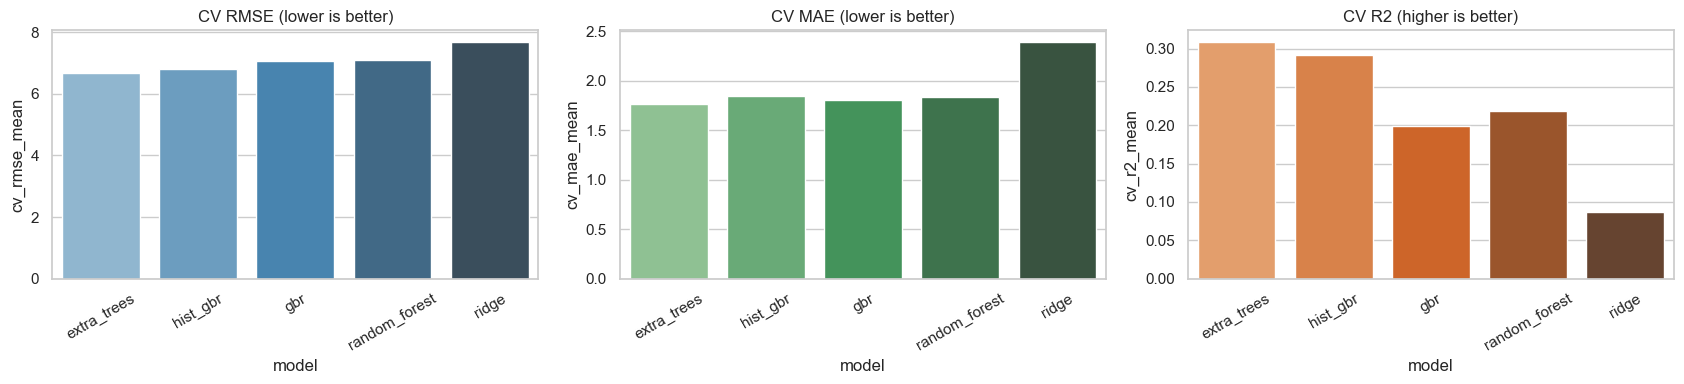

In [6]:

fig, axes = plt.subplots(1, 3, figsize=(17, 4))
sns.barplot(data=cv_df, x='model', y='cv_rmse_mean', ax=axes[0], palette='Blues_d')
axes[0].set_title('CV RMSE (lower is better)')
axes[0].tick_params(axis='x', rotation=30)

sns.barplot(data=cv_df, x='model', y='cv_mae_mean', ax=axes[1], palette='Greens_d')
axes[1].set_title('CV MAE (lower is better)')
axes[1].tick_params(axis='x', rotation=30)

sns.barplot(data=cv_df, x='model', y='cv_r2_mean', ax=axes[2], palette='Oranges_d')
axes[2].set_title('CV R2 (higher is better)')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


In [7]:

best_name = cv_df.iloc[0]['model']
best_model = models[best_name]

best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

test_metrics = {
    'test_rmse': float(np.sqrt(mean_squared_error(y_test, pred))),
    'test_mae': float(mean_absolute_error(y_test, pred)),
    'test_r2': float(r2_score(y_test, pred))
}

print('Best model:', best_name)
print(test_metrics)


Best model: extra_trees
{'test_rmse': 4.3383213167793935, 'test_mae': 1.64301651477549, 'test_r2': 0.26312350875162416}


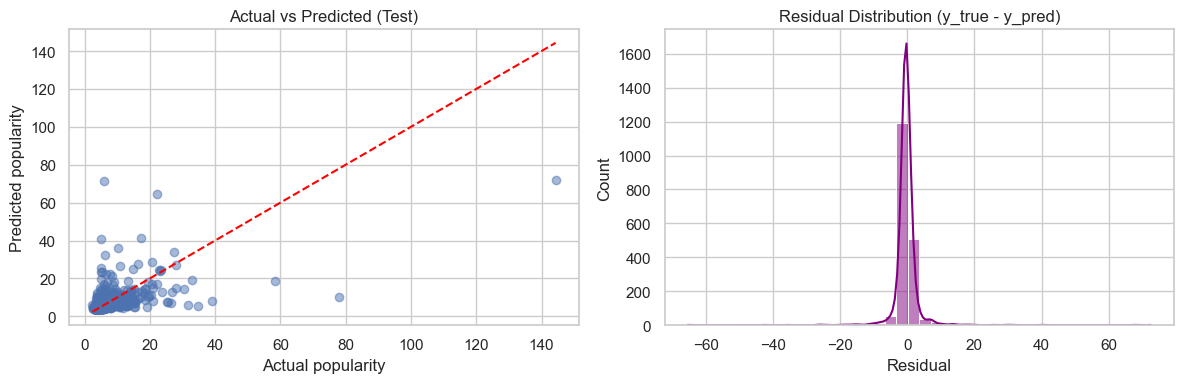

In [8]:

residuals = y_test - pred

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(y_test, pred, alpha=0.5)
line_min = min(y_test.min(), pred.min())
line_max = max(y_test.max(), pred.max())
axes[0].plot([line_min, line_max], [line_min, line_max], color='red', linestyle='--')
axes[0].set_title('Actual vs Predicted (Test)')
axes[0].set_xlabel('Actual popularity')
axes[0].set_ylabel('Predicted popularity')

sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Residual Distribution (y_true - y_pred)')
axes[1].set_xlabel('Residual')

plt.tight_layout()
plt.show()


In [9]:

X_proc = best_model.named_steps['preprocess'].transform(X_train)
feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
estimator = best_model.named_steps['model']

sample_n = min(250, X_proc.shape[0])
X_sample = X_proc[:sample_n]

if isinstance(estimator, (RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor)):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X_sample, check_additivity=False)
    shap_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values
elif isinstance(estimator, Ridge):
    explainer = shap.LinearExplainer(estimator, X_sample)
    shap_matrix = explainer.shap_values(X_sample)
else:
    explainer = shap.Explainer(estimator, X_sample)
    shap_matrix = explainer(X_sample).values

shap_importance = (
    pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': np.abs(shap_matrix).mean(axis=0)
    })
    .sort_values('mean_abs_shap', ascending=False)
    .reset_index(drop=True)
)

shap_importance.head(15)


,feature,mean_abs_shap
0,num__release_year,1.105189
1,num__log_budget,0.780268
2,num__star_count,0.392408
3,num__keyword_count,0.239717
4,num__is_holiday_release,0.234329
5,num__genre_Action,0.215767
6,num__actor1_popularity,0.147992
7,num__runtime,0.118284
8,num__genre_Science Fiction,0.108523
9,num__cast_pop_mean,0.097739


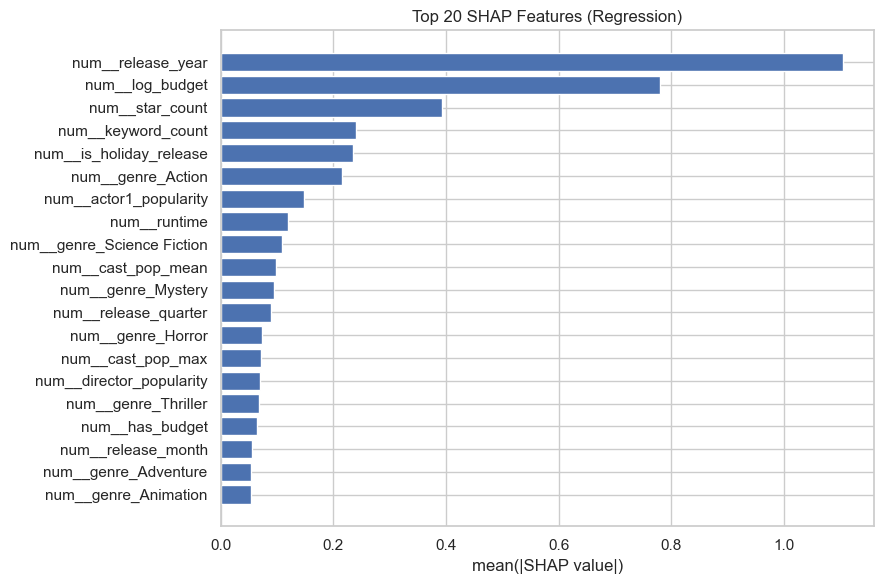

In [10]:

plt.figure(figsize=(9, 6))
plot_df = shap_importance.head(20).sort_values('mean_abs_shap', ascending=True)
plt.barh(plot_df['feature'], plot_df['mean_abs_shap'])
plt.title('Top 20 SHAP Features (Regression)')
plt.xlabel('mean(|SHAP value|)')
plt.tight_layout()
plt.show()


In [11]:

cv_df.to_csv(ARTIFACT_DIR / 'cv_results.csv', index=False)
shap_importance.to_csv(ARTIFACT_DIR / 'shap_feature_importance.csv', index=False)
with open(ARTIFACT_DIR / 'test_metrics.json', 'w', encoding='utf-8') as f:
    json.dump({'best_model': best_name, **test_metrics}, f, indent=2)

print('Saved artifacts to', ARTIFACT_DIR)


Saved artifacts to models/artifacts/regression
